In [1]:
from rainbow_mouse.models.first_model import LFPChannelEmbeddingModel
import os
import numpy as np
from dotenv import load_dotenv
load_dotenv()
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/home/maria/RainbowMouse/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cache_path = os.environ.get("RAINBOW_MOUSE_CACHE")
lfp_train = np.load(f"{cache_path}/lfp_X.npy")[:,:118*30] 
print(lfp_train.shape)          # [95, 5900]
frames_train = np.load(f"{cache_path}/lfp_y.npy")[:118*30]     # [5900]
vit_embeddings = np.load(f"{cache_path}/vit_embeddings.npy")  # [95, 48]
lfp_test = np.load(f"{cache_path}/lfp_X.npy")[:,118*30:] 
print(lfp_test.shape)     # [95, 5900]
frames_test = np.load(f"{cache_path}/lfp_y.npy")[118*30:]-1   # [5900]

device = "cuda" if torch.cuda.is_available() else "cpu"
model = LFPChannelEmbeddingModel()
PATH= f"{cache_path}/lfp_model.pth"
model.load_state_dict(torch.load(PATH))
model.eval()

(95, 3540)
(95, 2360)


LFPChannelEmbeddingModel(
  (channel_embed): Embedding(95, 64)
  (mlp): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [3]:
5900/118

118*20

2360

95 2360
Generating predictions for full test set...


100%|██████████| 95/95 [01:05<00:00,  1.46it/s]

[-1.09590670e-07 -8.89940209e-08 -1.36412944e-07 -1.27764099e-07
 -1.22003698e-07 -1.42205311e-07 -8.36357557e-08 -1.56275581e-07
 -1.50272044e-07 -1.28024588e-07 -1.08280995e-07 -1.76190820e-07
 -1.34850125e-07 -1.27690156e-07 -1.28167692e-07 -1.59917423e-07
 -1.24244033e-07 -1.67335763e-07 -1.73042626e-07 -1.31648721e-07
 -1.63622881e-07 -1.63912269e-07 -1.89562764e-07 -1.66052510e-07
 -1.96083109e-07 -1.43931744e-07 -1.74773553e-07 -2.14618189e-07
 -2.08161542e-07 -2.00241345e-07 -1.85963255e-07 -1.39494464e-07
 -1.70265414e-07 -1.43799460e-07 -1.37782502e-07 -1.38434589e-07
 -1.46670452e-07 -1.37926648e-07 -1.12800753e-07 -1.56790357e-07
 -1.75181304e-07 -2.14609463e-07 -2.42114171e-07 -2.42808776e-07
 -2.61045817e-07 -2.00888796e-07 -1.77209775e-07 -1.55930651e-07
 -1.76529186e-07 -1.58760205e-07 -1.87983788e-07 -1.75516802e-07
 -1.95582895e-07 -2.11122905e-07 -2.37642588e-07 -3.15096827e-07
 -2.86476219e-07 -2.18478106e-07 -1.57615716e-07 -1.23801820e-07
  2.97145054e-08 -3.60300

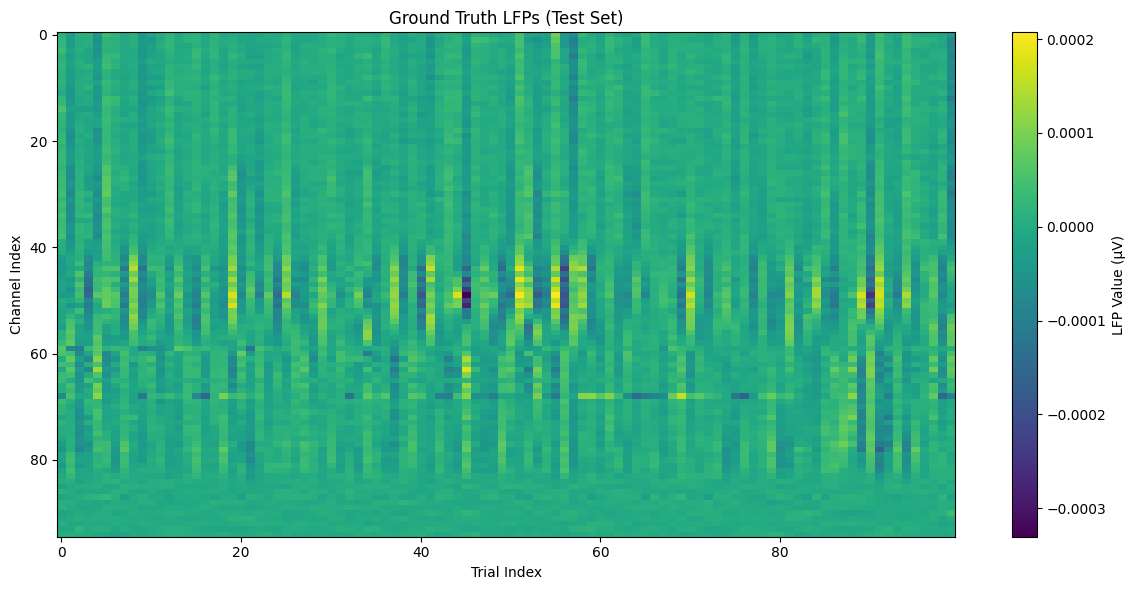

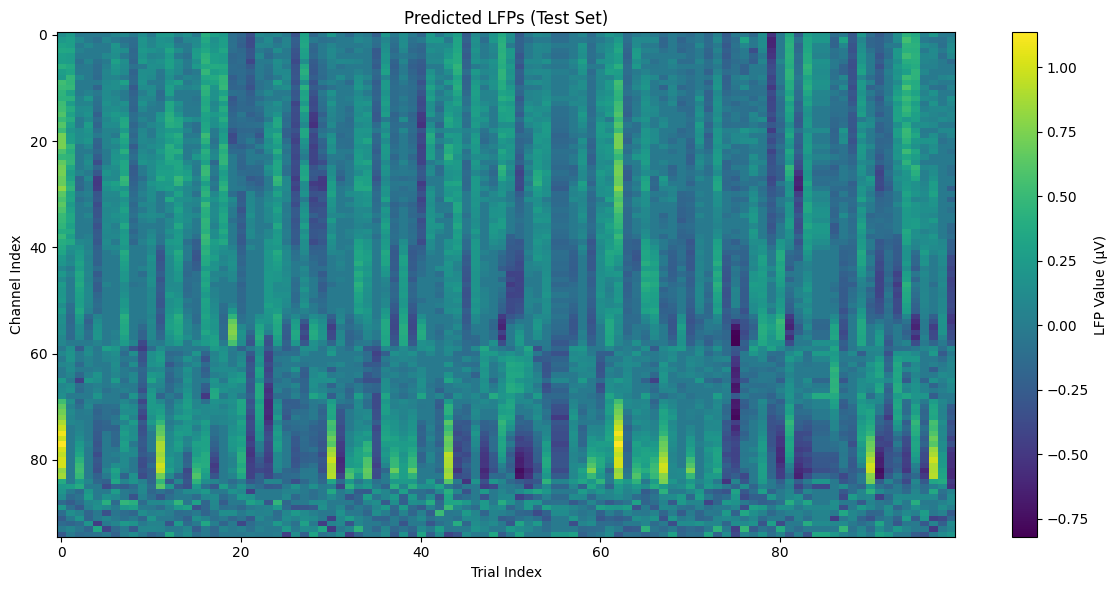

In [4]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Load data
cache_path = os.environ.get("RAINBOW_MOUSE_CACHE")
lfp_train = np.load(f"{cache_path}/lfp_X.npy")[:, :118*30]               # [95, 3540]
frames_train = np.load(f"{cache_path}/lfp_y.npy")[:118*30] -1              # [3540]
vit_embeddings = np.load(f"{cache_path}/vit_embeddings.npy")            # [118, 48]
lfp_test = np.load(f"{cache_path}/lfp_X.npy")[:, 118*30:]                # [95, 5900]
frames_test = np.load(f"{cache_path}/lfp_y.npy")[118*30:] - 1           # [5900], subtract 1 to align with ViT idx

lfp_train = (lfp_train - np.mean(lfp_train, axis=1, keepdims=True)) / np.std(lfp_train, axis=1, keepdims=True)
lfp_test = (lfp_test - np.mean(lfp_train, axis=1, keepdims=True)) / np.std(lfp_train, axis=1, keepdims=True)

# Load model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LFPChannelEmbeddingModel().to(device)
model.load_state_dict(torch.load(f"{cache_path}/lfp_model.pth"))
model.eval()

# Predict full test set
n_channels, n_trials = lfp_test.shape
lfp_preds = np.zeros((n_channels, n_trials))

print(n_channels, n_trials)

print("Generating predictions for full test set...")

for channel in tqdm(range(n_channels)):
    for trial in range(n_trials):
        frame_idx = frames_test[trial]  # this is the image/frame shown during this trial

        vit_input = torch.tensor(vit_embeddings[frame_idx], dtype=torch.float32).to(device)
        channel_tensor = torch.tensor([channel], dtype=torch.long).to(device)

        with torch.no_grad():
            pred = model(vit_input.unsqueeze(0), channel_tensor).cpu().item()

        lfp_preds[channel, trial] = pred

# Plotting as heatmaps
def plot_lfp_heatmap(data, title):
    plt.figure(figsize=(12, 6))
    plt.imshow(data, aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar(label='LFP Value (µV)')
    plt.title(title)
    plt.xlabel("Trial Index")
    plt.ylabel("Channel Index")
    plt.tight_layout()
    plt.show()
print(lfp_test.mean(axis=1))
plot_lfp_heatmap(lfp_test[:,:100], "Ground Truth LFPs (Test Set)")
plot_lfp_heatmap(lfp_preds[:,:100], "Predicted LFPs (Test Set)")


In [5]:
print(set(frames_train))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, -1}


In [6]:
lfp_preds.shape

(95, 2360)

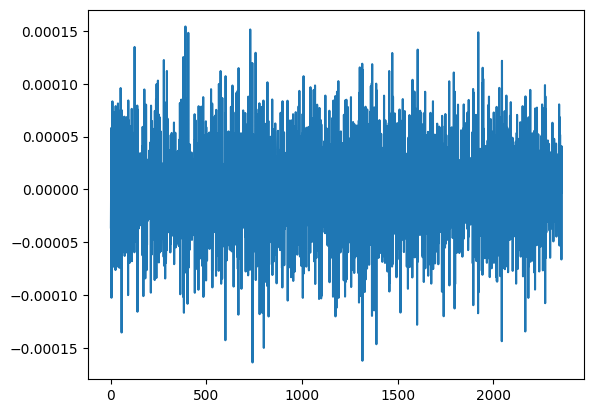

In [7]:
plt.plot(lfp_test[45,:], label="True LFP")

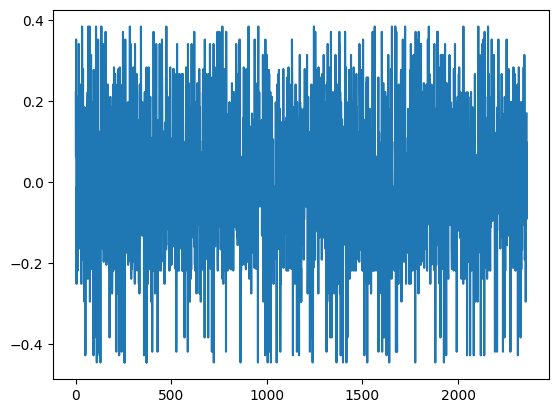

In [8]:
plt.plot(lfp_preds[45,:], label="Predicted LFP")

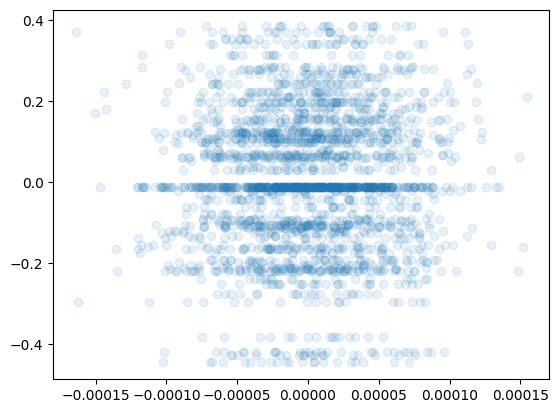

In [9]:
plt.scatter(lfp_test[45,:], lfp_preds[45,:], alpha=0.1, label="Predicted LFP vs True LFP")

In [10]:
import torch
print(torch.cuda.is_available())

True


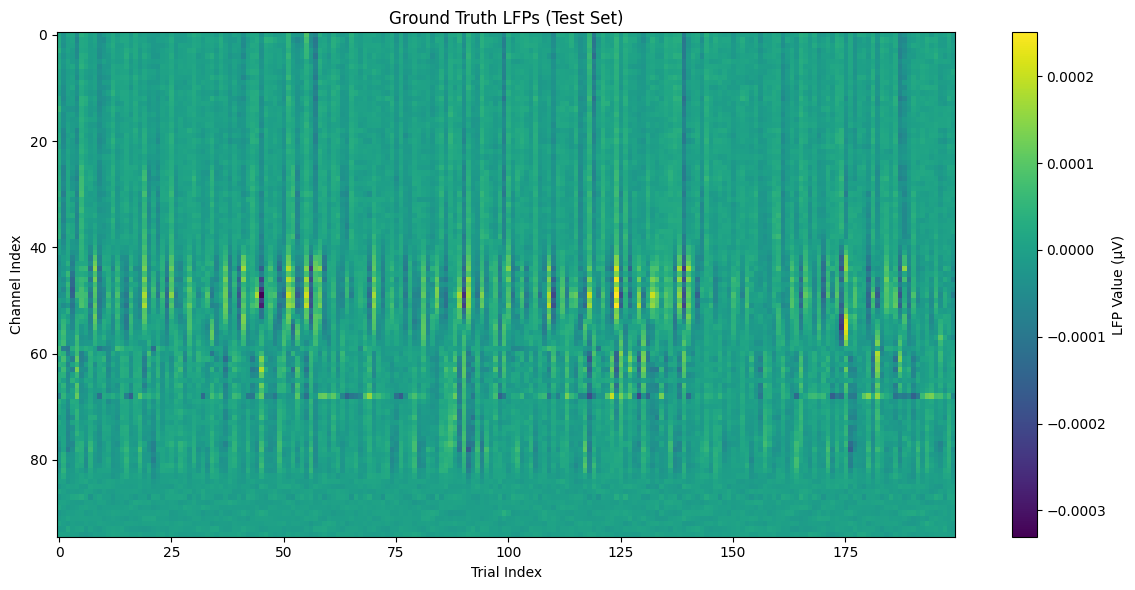

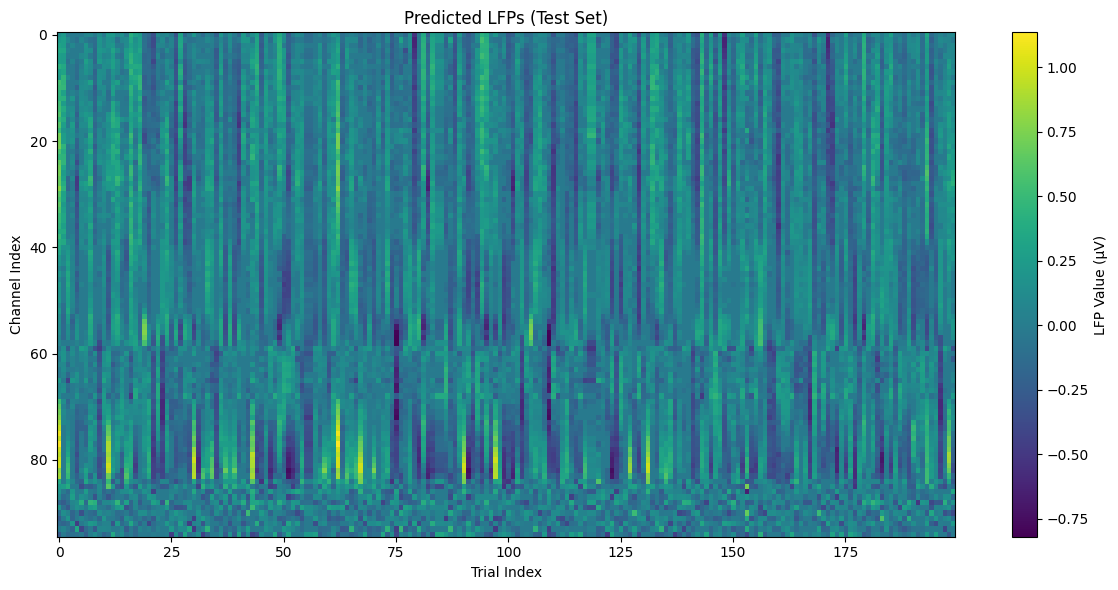

In [11]:
plot_lfp_heatmap(lfp_test[:,:200], "Ground Truth LFPs (Test Set)")
plot_lfp_heatmap(lfp_preds[:,:200], "Predicted LFPs (Test Set)")

NameError: name 'aligned_lfp_test' is not defined